In [1]:
%cd '/content/drive/MyDrive/Software Engineer Assessment/'

/content/drive/MyDrive/Software Engineer Assessment


# 1.

In [2]:
import pandas as pd

In [3]:
class ProcessGameState:
  def load(self, filepath):
    # Read data from specified parquet file into a pandas dataframe.
    self.data = pd.read_parquet(filepath)

  def raycast(self, coordinates, z, point):
    # The raycast algorithm will determine if a point is within some polygon
    # (i.e. the boundary) if a ray starting from a specified point intersects
    # an odd number of edges.

    edge_count = 0
    z_lower, z_upper = z
    xp, yp, zp = point

    # Check if the point's z value is within z-axis bounds.
    if not z_lower <= zp <= z_upper:
      return False

    # Count number of edges the ray will intersect.
    coordinate_count = len(coordinates)
    for i in range(coordinate_count):
      c1 = coordinates[i]
      c2 = coordinates[(i + 1) % coordinate_count]

      # Set c1 to have a smaller y-value than that of c2.
      if c1[1] > c2[1]:
        c1, c2 = c2, c1
      
      x1, y1 = c1
      x2, y2 = c2
      if y1 <= yp <= y2 and xp <= max(x1, x2):
        edge_count += 1
    
    return edge_count % 2 == 1
        
  def inbounds(self, coordinates, z):
    # Retrieve dataframe of whether rows are within the boundary.
    return self.data.apply(lambda row: self.raycast(coordinates, z, (row['x'], row['y'], row['z'])), axis=1)
  
  def get_weapon_classes(self, inventory):
    # Extract weapon classes from inventory.
    weapons = inventory.explode('inventory')
    classes = {}
    for w in weapons:
      if w:
        classes[w['weapon_class']] = classes.get(w['weapon_class'], 0) + 1
    return classes

# 2.

In [4]:
# Initialization step for our dataset
game_state = ProcessGameState()
game_state.load('./data/game_state_frame_data.parquet')
coordinates = [(-1735, 250), (-2024, 398), (-2806, 742), (-2472, 1233), (-1565, 580)]
z = [285, 421]
data = game_state.data

## (a)


In [5]:
# Find number of rounds Team2 is on T side
round_count = data[(data['team'] == 'Team2') & (data['side'] == 'T')].groupby('round_num').ngroups

# Only include data within light blue boundary
bounds = data[game_state.inbounds(coordinates, z)]

# Find number of rounds Team 2 on T side is within light blue boundary
entry_count = bounds[(bounds['team'] == 'Team2') & (bounds['side'] == 'T')].groupby('round_num').ngroups

print(f'Team 2 on T side entered the boundary in {entry_count} rounds out of {round_count}')

Team 2 on T side entered the boundary in 2 rounds out of 15


Entering via the light blue boundary does not seem to be a common strategy used by Team 2 on T side.

## (b)

In [6]:
from datetime import timedelta

In [7]:
def rifle_smg_sum(row):
  classes = game_state.get_weapon_classes(row['inventory'])
  rifle_count = classes.get('Rifle', 0)
  smg_count = classes.get('SMG', 0)
  if rifle_count + smg_count >= 2:
    return row['clock_time']

In [8]:
# Retrieve data of Team2 players on T side inside BombsiteB
t2t_siteb = data[(data['team'] == 'Team2') & (data['side'] == 'T') & (data['area_name'] == 'BombsiteB')]

# Count rifles and SMGs in each round at a certain time
t2t_siteb = t2t_siteb.groupby(['round_num', 'clock_time']).apply(lambda x: rifle_smg_sum(x)).dropna()

# Retrieve earliest entry time for each round
t2t_siteb = t2t_siteb.to_frame().groupby(['round_num']).first()

# Calculate average clock time
round_count = len(t2t_siteb[0])
total = timedelta()
for time in t2t_siteb[0]:
  mins, secs = time.split(':')
  total += timedelta(minutes=int(mins), seconds=int(secs))

print(f'Average clock timer Team 2 on T side enters BombsiteB with at least 2 rifles or SMGs: {total / round_count}')

Average clock timer Team 2 on T side enters BombsiteB with at least 2 rifles or SMGs: 0:00:55.400000


Team 2 on T side enters "BombsiteB" with at least 2 rifles or SMGs on average when the clock timer is 00:55.40 (i.e. between 00:55 and 00:56).


## (c)

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

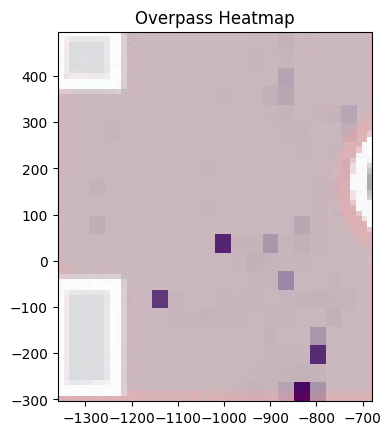

In [10]:
# Retrieve data of Team2 players on CT side inside BombsiteB
t2ct_siteb = data[(data['team'] == 'Team2') & (data['side'] == 'CT') & (data['area_name'] == 'BombsiteB')]

# Plot heatmap on top of map image
map_img = mpimg.imread('./map/de_overpass_radar.jpeg')
x = t2ct_siteb['x'].tolist()
y = t2ct_siteb['y'].tolist()

H, xedges, yedges = np.histogram2d(x, y, bins=20)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(map_img[300:370, 690:745, :], extent=extent)
plt.imshow(H.T, extent=extent, cmap=plt.get_cmap("Purples"), alpha=0.7)
plt.title('Overpass Heatmap')
plt.show()

# 3.

One solution is to design a user interface that the CS:GO coaching staff can interact with, such as a website or application. That user interface would be connected to our API so that the coaching staff would not need to write any code to retrieve the output themselves. The coaching staff only needs to provide an ordered list of coordinates and z-axis bounds via a text file, text input, or interactive map if time permits, and a file with the game state data.